## Solvent/Solute splitting using g-BAOAB

### Imports

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import time
from openmmtools import testsystems 
from openmmtools.forcefactories import split_nb_using_exceptions,split_nb_using_subtraction
from simtk.openmm.app import Simulation
from openmmtools.integrators import LangevinIntegrator
from simtk import unit
import simtk.openmm as mm
import mdtraj as md
from mdtraj.reporters import HDF5Reporter
import h5py
import seaborn as sbn
# Set seaborn constants
sbn.set()

### Define the test system (Solvated alanine dipeptide)

In [98]:
# Test system defined here
testsystem = testsystems.AlanineDipeptideExplicit()  

# Split the system into the different interactions using the
# routine from forcefactories.py
# This creates a copy of the system, with defined exceptions
new_system = split_nb_using_exceptions(testsystem.system, testsystem.mdtraj_topology) 

# Set gamma
collision_rate = 1/unit.picoseconds

# Set precision. Double takes ages, so we use mixed.
myprecision='mixed'
platform=mm.Platform.getPlatformByName('OpenCL')
platform.setPropertyDefaultValue('OpenCLPrecision', myprecision)

# We define four splittings, and loop over them
midstr = ' V1 R R O R R V1'       
splitting0='V0'+midstr*1+' V0'    # K_p=1, i.e. BAOAB
splitting1='V0'+midstr*2+' V0'    # K_p=2, i.e. B_s (B_p A O A B_p)^2 B_s
splitting2='V0'+midstr*3+' V0'    # K_p=3, i.e. B_s (B_p A O A B_p)^3 B_s
splitting3='O V R R V O'          # The OBABO scheme

splittings = [splitting0,
             splitting1,
             splitting2,
             splitting3]

# We look at the properties of simulations from seven stepsizes, given in fs
dts = np.array([2.0,3.0,4.0,6.0,8.0,9.0,10.0])

# Set the constraint tolerance. 
tol = 1e-8

# Total simulation time in ps
T = 1000

### Run the simulations

In [3]:
start_time=time.time()
for split_i,splitting in enumerate(splittings):
    for dt_j,dt in enumerate(dts): 
            
        integrator = LangevinIntegrator(splitting=splitting, 
                                 collision_rate=collision_rate, 
                                 timestep= dt * unit.femtosecond,
                                   constraint_tolerance=tol) 

        # Set up the simulation
        sim = Simulation(testsystem.topology, 
                     new_system, 
                     integrator,
                     platform=platform)
        sim.context.setPositions(testsystem.positions) 
        sim.context.setVelocitiesToTemperature(298*unit.kelvin)
        path = 'x_'+str(split_i)+'_'+str(dt_j)
        sim.reporters.append(HDF5Reporter('Results/'+path+'.h5', 50))

        N = int(1000*T/dt)
        st=time.time()
        try: 
            sim.step(N) 
            completed=True
        except:
            completed=False
            
        wall_time = time.time()-st 
        
        if (completed):
            print('Splitting #'+str(split_i) +
                  ' at '+str(dt)+'fs took '+str(np.round(wall_time,2))+
                  's, average time per step: '+str(wall_time/N))
    print('')
        
print('')
print('Total time: '+str(np.round(time.time()-start_time,3)))

Splitting #0 at 2.0fs took 618.79s, average time per step: 0.0012375768299102783
Splitting #0 at 3.0fs took 419.7s, average time per step: 0.0012591124179602267
Splitting #0 at 4.0fs took 307.78s, average time per step: 0.0012311247854232788

Splitting #1 at 2.0fs took 829.53s, average time per step: 0.0016590503101348876
Splitting #1 at 3.0fs took 536.57s, average time per step: 0.0016097264982896545
Splitting #1 at 4.0fs took 400.66s, average time per step: 0.0016026454448699952
Splitting #1 at 6.0fs took 270.65s, average time per step: 0.0016239209086589459
Splitting #1 at 8.0fs took 197.85s, average time per step: 0.0015828157482147217
Splitting #1 at 9.0fs took 173.9s, average time per step: 0.0015651141959583121
Splitting #1 at 10.0fs took 156.01s, average time per step: 0.0015600841689109802

Splitting #2 at 2.0fs took 949.43s, average time per step: 0.0018988531966209411
Splitting #2 at 3.0fs took 631.43s, average time per step: 0.0018943008173164118
Splitting #2 at 4.0fs took 

### Look at the average PE of the system

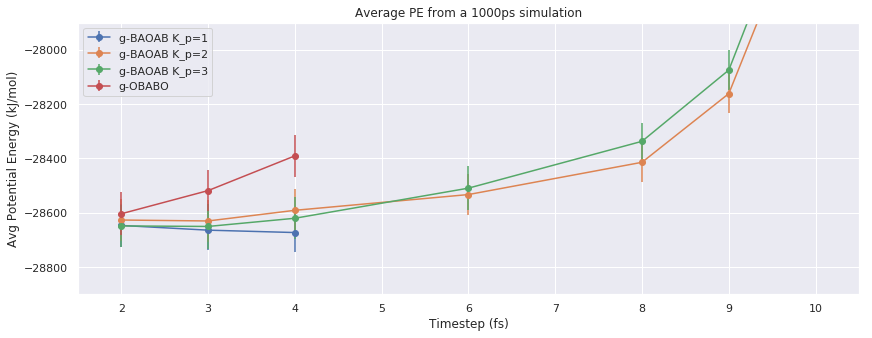

In [99]:
batches=4
split_str = ['g-BAOAB K_p=1','g-BAOAB K_p=2','g-BAOAB K_p=3','g-OBABO']
plt.figure(figsize=[14,5])
H = []

for ii in range(len(split_str)):
    res=[]
    err=[]
    h = []
    for jj in range(len(dts)): 
        try:
            y=h5py.File('Results/x_'+str(ii)+'_'+str(jj)+'.h5')
            pe = np.array(y['potentialEnergy'])
            pe = pe[len(pe)//10:]
            if(len(pe)<2):
                raise
                
            h += [ np.histogram(pe, np.linspace(-29500,-26000,25),density=True)[0]]
            pe=pe[:batches*(len(pe)//batches)].reshape(-1,batches)
            y.close()
            if (np.mean(pe)>-2000):
                res+=[np.nan]
                err+=[np.nan]
            else:
                res += [np.mean(pe)]
                err += [np.std(np.mean(pe,1))/np.sqrt(batches)]
        except:
            res += [np.nan]
            err += [np.nan]
        
    plt.errorbar(dts,res,err,None,'o-',label=split_str[ii])
    H+=[h]
plt.legend()
plt.grid(1)
plt.ylim([-28900,-27900])
plt.xlim([1.5,10.5])
plt.title('Average PE from a '+str(T)+'ps simulation')
plt.xlabel('Timestep (fs)')
plt.ylabel('Avg Potential Energy (kJ/mol)')
plt.show()


### PE Distributions

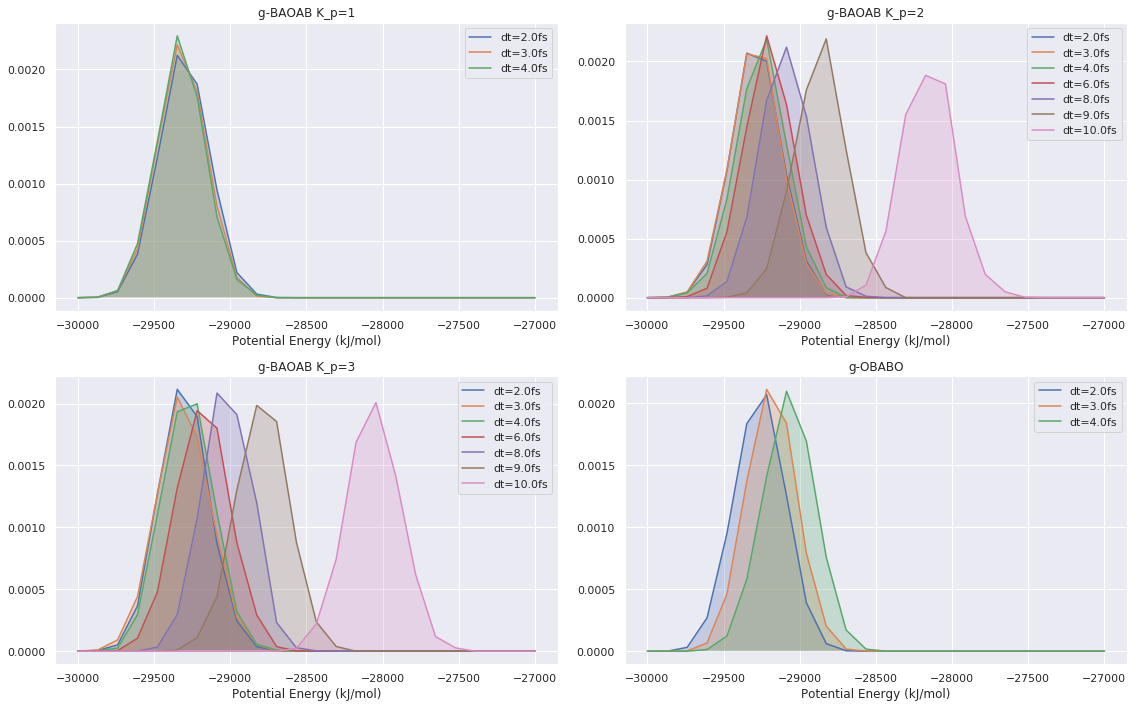

In [100]:
xx=np.linspace(-30000,-27000,24)
plt.figure(figsize=[16,10])
for jj in range(4):
    plt.subplot(2,2,jj+1)
    for ii in range(7):
        try:
            plt.plot( xx,H[jj][ii],label='dt='+str(dts[ii])+'fs')
            plt.fill( xx,H[jj][ii],alpha=0.25 )
        except:
            break
    plt.xlabel('Potential Energy (kJ/mol)')
    plt.title(split_str[jj])
    plt.legend()
plt.tight_layout()
plt.show()